In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
ROOT_PATH = '../data/jpg/'

In [4]:
import os
import pandas as pd

In [6]:
image_list = os.listdir(ROOT_PATH)

In [7]:
image_list[:5]

['image_07088.jpg',
 'image_06396.jpg',
 'image_05847.jpg',
 'image_04581.jpg',
 'image_03588.jpg']

In [8]:
# https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [9]:
img = [plt.imread(os.path.join(ROOT_PATH, p)) for p in image_list[:5]]

<ipython-input-8-b6191dd2c4a1>:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


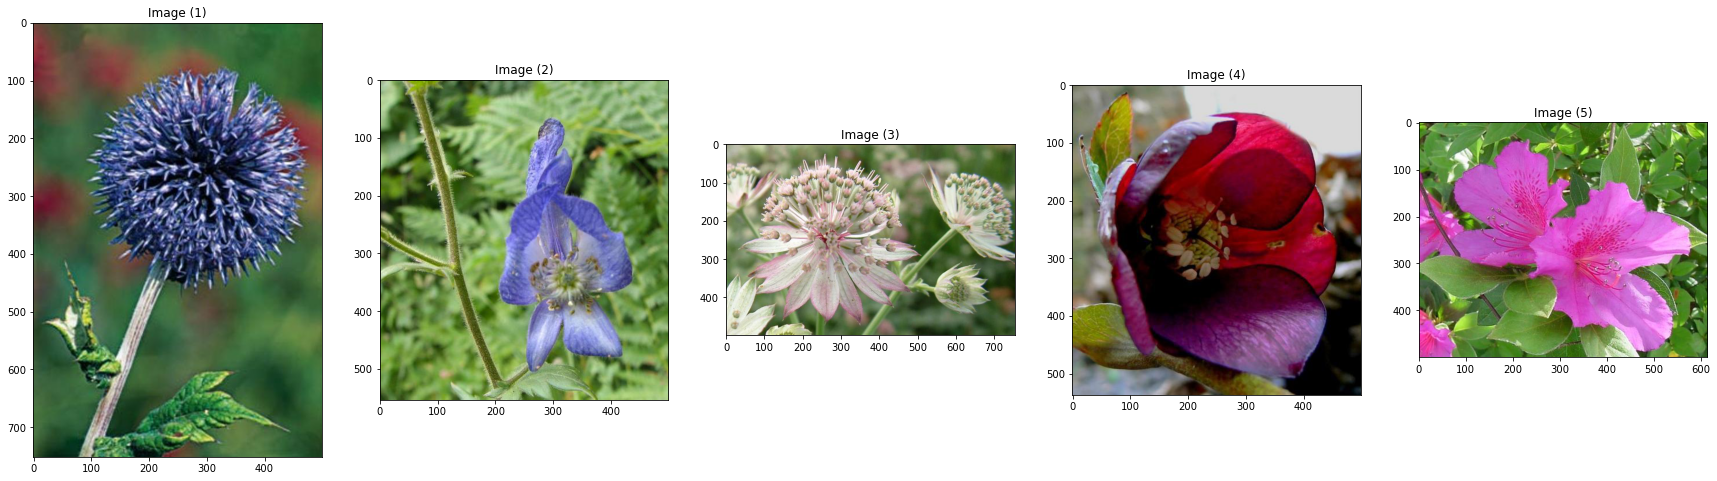

In [10]:
show_images(img)

In [11]:
from torch.utils.data import Dataset

import glob
from PIL import Image

In [12]:
class ImageDataset(Dataset):
    def __init__(self, folder, tfms = None):
        self.folder = folder
        self.files = glob.glob(os.path.join(self.folder, '*.jpg'))

        self.tfms = tfms

    def __getitem__(self, index):
        img = Image.open(self.files[index])
        if self.tfms:
            img = self.tfms(img)
        return img, self.files[index]

    def __len__(self):
        return len(self.files)

In [13]:
ds = ImageDataset(ROOT_PATH)

In [14]:
ds[0]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x752 at 0x7F9024DF1160>,
 '../data/jpg/image_07088.jpg')

In [15]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import (Dataset, DataLoader)
import os
import numpy as np
import random

tfms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                                 std = [ 0.229, 0.224, 0.225 ])
])

def get_transform_with_norm():
    return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                                 std = [ 0.229, 0.224, 0.225 ])
    ])

def get_transform():
    return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])

In [16]:
sample = random.choices(range(len(ds)), k=10)

In [17]:
ds = ImageDataset(ROOT_PATH, get_transform())
imgs = [np.array(ds[s][0]) for s in sample]

<ipython-input-8-b6191dd2c4a1>:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


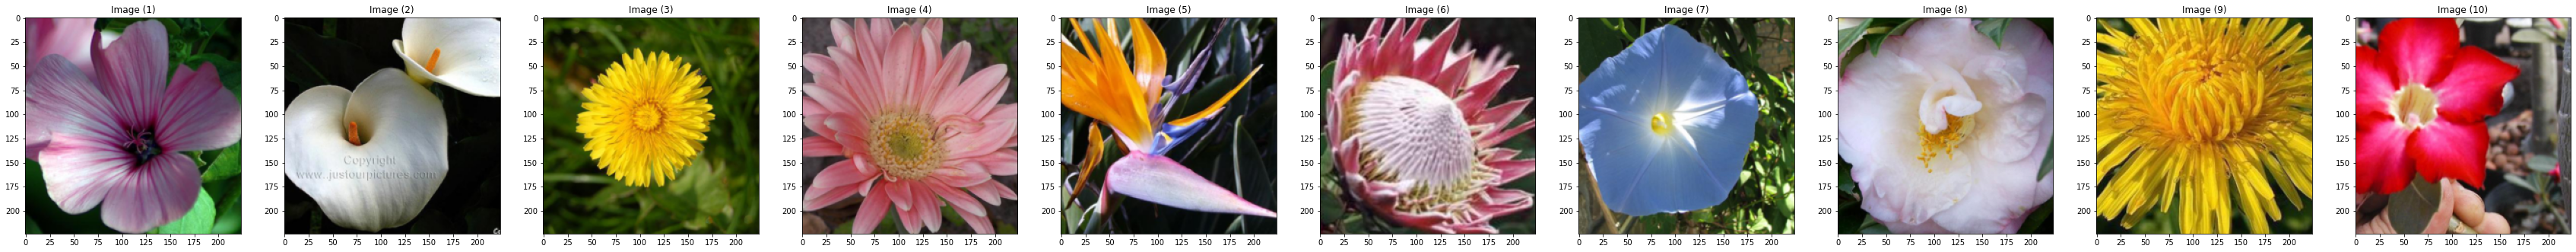

In [18]:
show_images(imgs)

In [19]:
import torch.nn as nn
import torch
import torchvision.models as models

resnet18 = models.resnet.resnet18(pretrained=True)
resnet18_feature = nn.Sequential(*(list(resnet18.children())[:-1]))

In [20]:
bs = 64
ds = ImageDataset(ROOT_PATH, get_transform_with_norm())
dl = DataLoader(ds, batch_size=bs)

In [21]:
from tqdm.notebook import tqdm

torch.set_grad_enabled(False)

resnet18_feature.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18_feature.to(device)

feature_map = dict()
for batch_index, (img, path) in tqdm(enumerate(dl), total=len(dl)):
    img = img.to(device)
    feature = resnet18_feature(img).squeeze().cpu()
    for i, p in enumerate(path):
        feature_map[p] = feature[i].numpy()

  0%|          | 0/128 [00:00<?, ?it/s]

/Users/phucbb/opt/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459065530/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [22]:
paths = [i for i, _ in feature_map.items()]
features = np.array([j for _, j in feature_map.items()])

In [23]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(features)

In [24]:
query = 110

q_feature = features[query]

distances, indicates = nbrs.kneighbors(q_feature.reshape(1, -1), n_neighbors=8)

<ipython-input-8-b6191dd2c4a1>:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


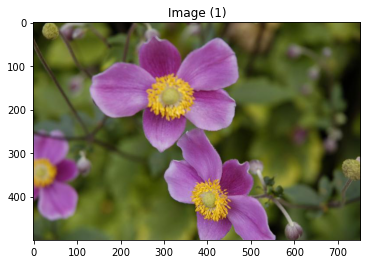

In [25]:
q_img = Image.open(paths[query])

result_image = [np.array(Image.open(paths[i])) for i in list(indicates.reshape(-1))]
show_images([np.array(q_img)])

<ipython-input-8-b6191dd2c4a1>:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


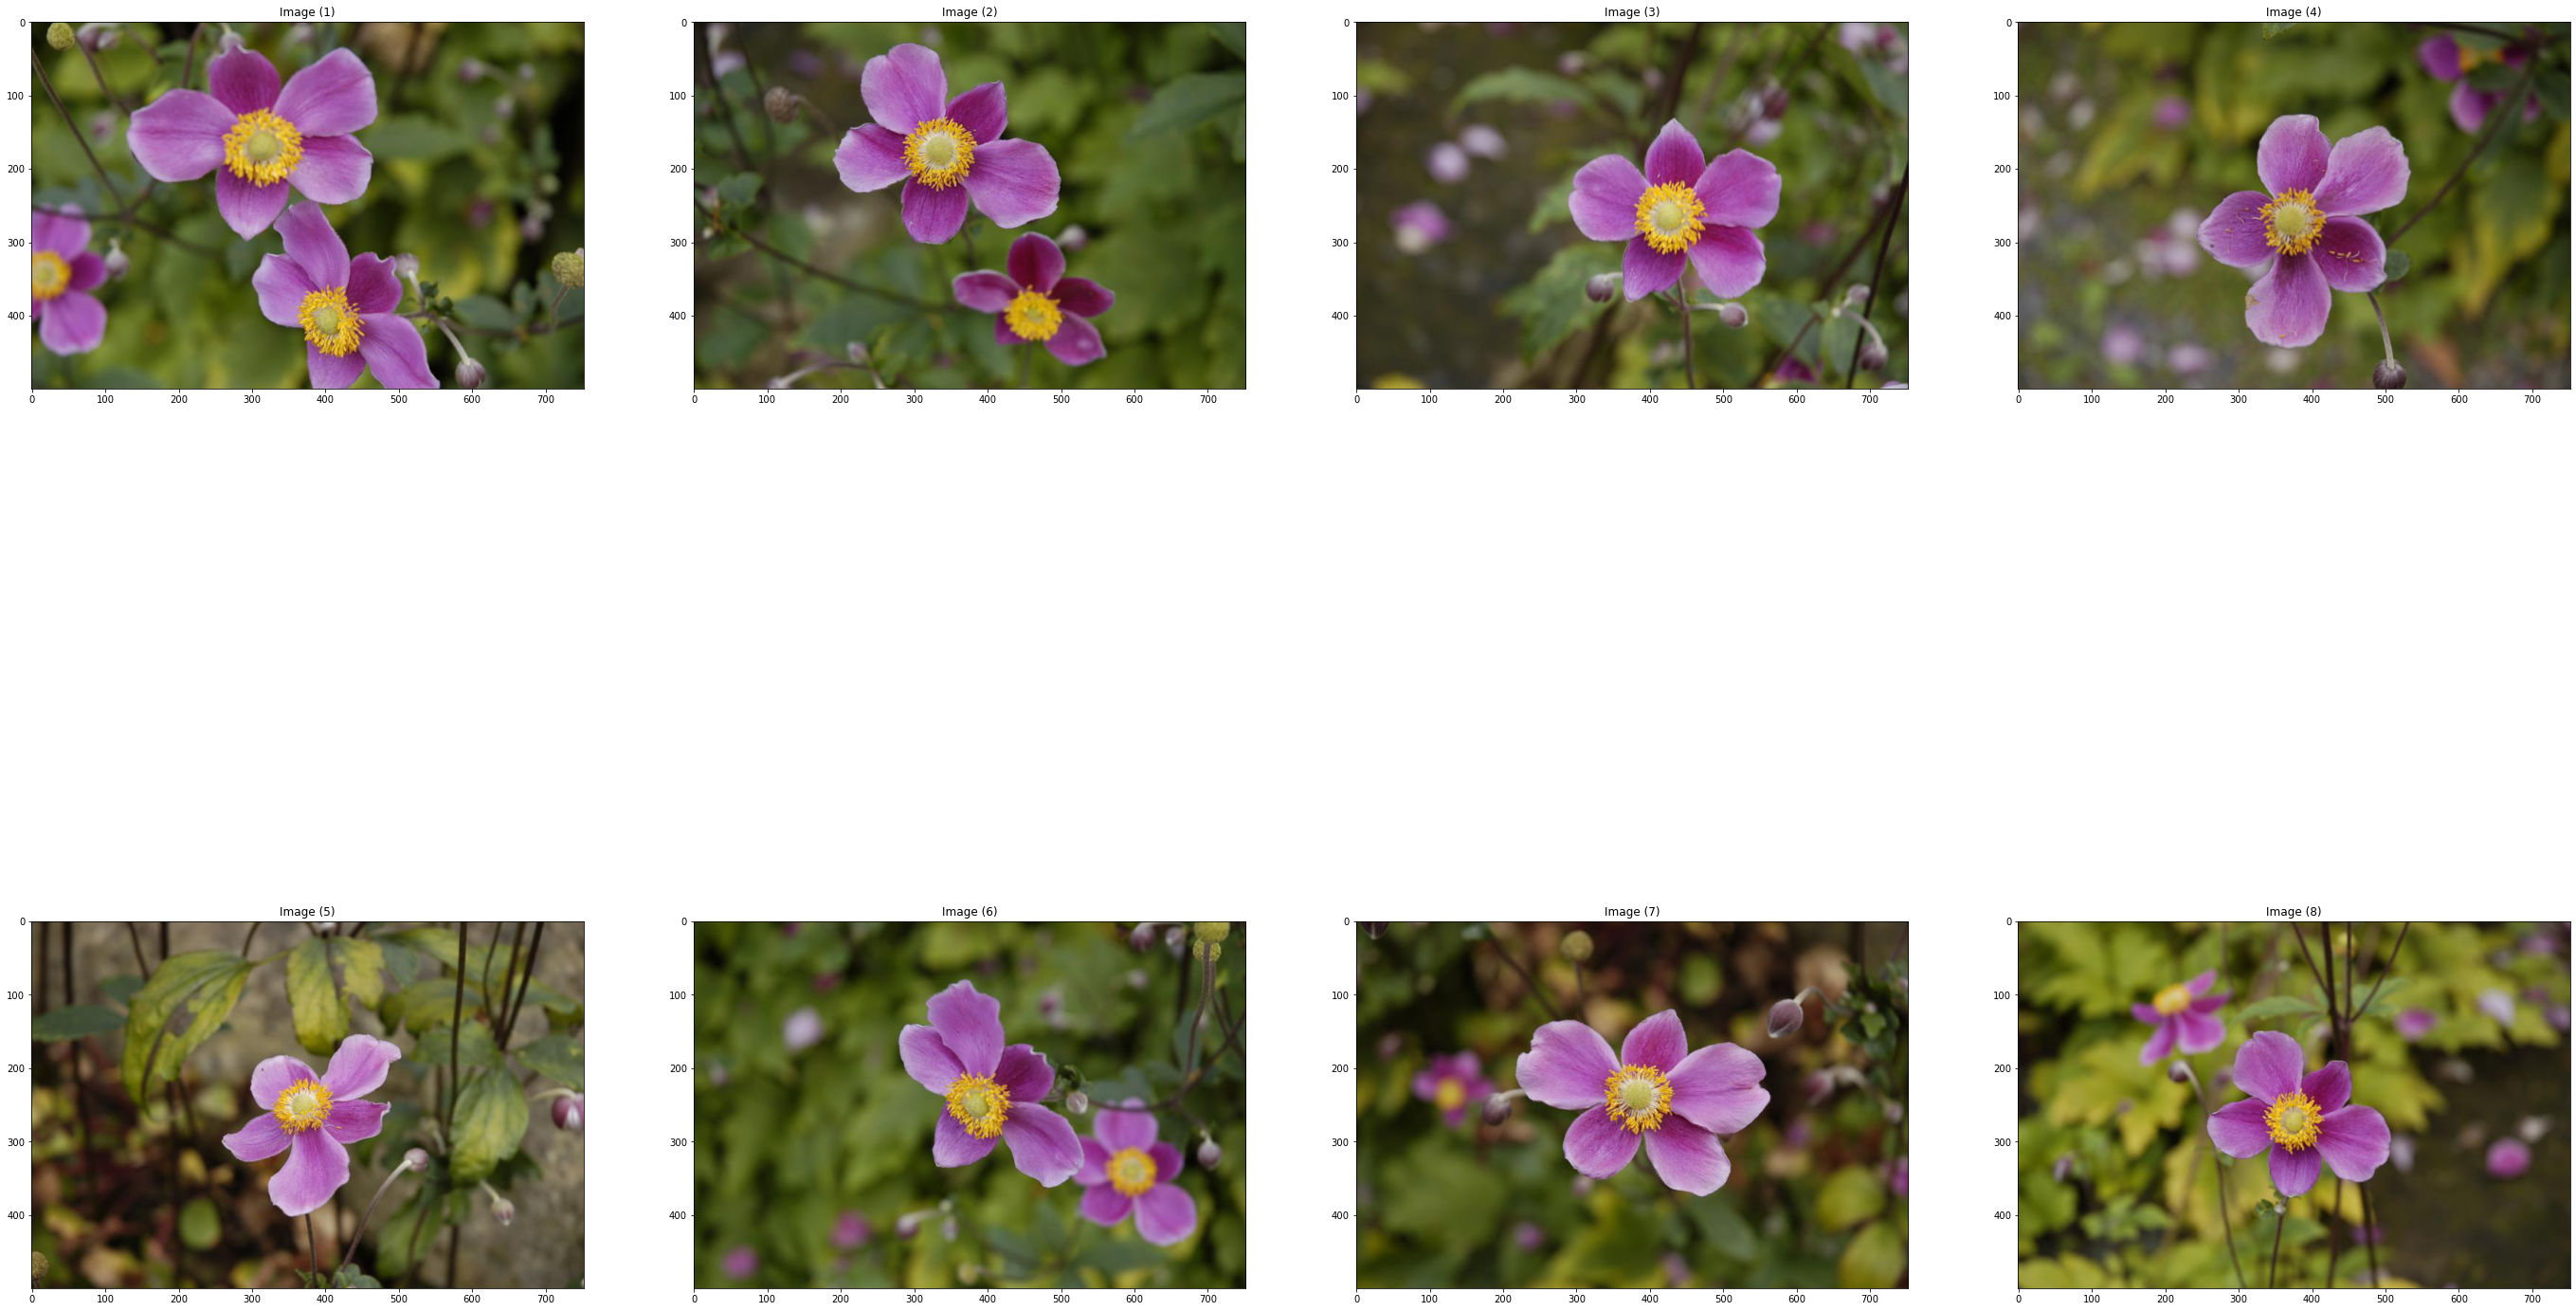

In [26]:
show_images(result_image, cols=2)

In [28]:
import pickle

In [29]:
with open('vectorDict.pickle', 'wb') as handle:
    pickle.dump(feature_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
!ls -la

total 40656
drwxr-xr-x   7 phucbb  staff       224 Oct  1 13:00 .
drwxr-xr-x  12 phucbb  staff       384 Oct  1 12:57 ..
drwxr-xr-x   3 phucbb  staff        96 Sep 26 16:38 .ipynb_checkpoints
-rw-r--r--   1 phucbb  staff   2951554 Oct  1 12:59 SimilarImage.ipynb
drwxr-xr-x   3 phucbb  staff        96 Sep 27 22:07 data
-rw-r--r--   1 phucbb  staff       871 Sep 27 22:09 ray_trainer.py
-rw-r--r--   1 phucbb  staff  17232072 Oct  1 13:00 vectorDict.pickle


In [32]:
!ls -1 ../data/jpg/*.jpg  | wc -l

    8189
